# Optimizing Multi-Qubit Violations for the $I_{3322}$ Bell Inequality

This notebook explores the quantum violation of the $I_{3322}$ Bell inequality with respect to bipartite non-signaling scenarios with multi-qubit Hilbert spaces at each measurement node.
Details regarding the inequality and ansatzes can be found in the `qnetvo` documentation.
For inputs $x,y\in \{0,1,2\}$ and outputs $a,b\in \{0,1\}$, the $I_{3322}$ Bell inequality is expressed as

\begin{align}
    I_{3322} := &-P_A(0|0) -2P_B(0|0) - P_B(0|1) + P(00|00) +P(00|01) + P(00|02) \\
    &+ P(00|10) + P(00|11) - p(00|12) + P(00|20) - P(00|21) 
\end{align}

The classical upper bound is $I_{3322} \leq \beta_C = 0$.
The upper bound for local qubit Hilbert spaces is known to be $I_{3322}\leq \beta_Q = 0.25$.
The amount of quantum violation increases slightly with larger Hilbert space dimensions.
Bounds for the infinite dimensional quantum case were produced by [K. Pal and T. Vertesi](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.82.022116) and found to be $I_{3322}\leq \beta_Q \leq 0.250\: 875\: 38$.
Our framework is able to produce the $0.25$ quantum violation across a range of multi-qubit ansatzes, however, we do not found any quantum violations exceeding $\beta_Q = 0.25$.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time

from context import qnetvo as QNopt

## Qubit Case

Using an arbitrary qubit parameterization, the maximal violation is found to be close to 0.25 for local measurements on single qubits.

In [2]:
local_qubits = 1

prepare_nodes = [QNopt.PrepareNode(1,range(2*local_qubits),qml.templates.subroutines.ArbitraryUnitary, 4**(2*local_qubits)-1)]
measure_nodes = [
    QNopt.MeasureNode(3,2, [0], qml.templates.subroutines.ArbitraryUnitary, 4**(local_qubits) - 1),
    QNopt.MeasureNode(3,2, [1], qml.templates.subroutines.ArbitraryUnitary, 4**(local_qubits) - 1)
]

qubit_ansatz = QNopt.NetworkAnsatz(prepare_nodes, measure_nodes)

In [3]:
# perform gradient descent
init_settings = qubit_ansatz.rand_scenario_settings()
I_3322_cost = QNopt.I_3322_bell_inequality_cost(qubit_ansatz) 

opt_dict = QNopt.gradient_descent(I_3322_cost, init_settings, step_size = 0.25, num_steps=150)
print("optimal score : ", opt_dict["opt_score"])

iteration :  0 , score :  -0.8755200499387308
iteration :  25 , score :  0.06697930940947994
iteration :  50 , score :  0.18543757200523314
iteration :  75 , score :  0.24291075160432896
iteration :  100 , score :  0.24933227295762517
iteration :  125 , score :  0.24991681629176732
optimal score :  0.24998794314824957


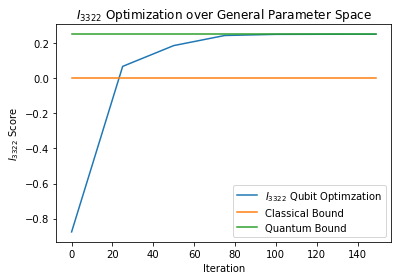

In [4]:
# Plot the score of the Bell throughout the optimization inequality
plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"$I_{3322}$ Qubit Optimzation")
plt.plot(opt_dict["samples"], [0]*len(opt_dict["samples"]), label = "Classical Bound")
plt.plot(opt_dict["samples"], [0.25]*len(opt_dict["samples"]), label = "Quantum Bound")
plt.title(r"$I_{3322}$ Optimization over General Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

## Multi-Qubit Case

In the multi-qubit case for the $I_{3322}$ inequality, Alice and Bob have have access to a larger shared Hilbert space.
This allows more flexibility in the entanglement shared between Alice and Bob.
We'll now show the $I_{3322}$ optimization over examples of different prepare and measure ansatzes.
We note that our optimizations can be run with relative efficiency for up to 10-qubits total.

### GHZ State Preparation and Local RY and RX Rotated Measurements

Here we investigate the case where Alice and Bob share a GHZ state prepared on $2N$-qubits where Alice and Bob each hold $N$ qubits locally with $N\in[1,5]$.

In [ ]:
np.random.seed(7)
sampled_optimizations = []
for n_local_qubits in range(1,6):
    ghz_prepare_nodes = [QNopt.PrepareNode(1,range(2*n_local_qubits),QNopt.ghz_state, 0)]
    local_rxry_measure_nodes = [
        QNopt.MeasureNode(3,2, range(n_local_qubits), QNopt.local_RXRY, 2*n_local_qubits),
        QNopt.MeasureNode(3,2, range(n_local_qubits, 2*n_local_qubits), QNopt.local_RXRY, 2*n_local_qubits)
    ]

    ghz_local_rxry_ansatz = QNopt.NetworkAnsatz(ghz_prepare_nodes, local_rxry_measure_nodes)
    
    opt_dict = {"opt_score" : 0}
    while opt_dict["opt_score"] < 0.24:
        print("n_local_qubits : ", n_local_qubits)
        ghz_local_rxry_settings = ghz_local_rxry_ansatz.rand_scenario_settings()
        I_3322_cost_ghz_local_rxry = QNopt.I_3322_bell_inequality_cost(ghz_local_rxry_ansatz) 
    
        start = time.time()
        opt_dict = QNopt.gradient_descent(I_3322_cost_ghz_local_rxry, ghz_local_rxry_settings, step_size = 0.2, num_steps=250, sample_width=50)
        stop = time.time()
        print("opt_score : ", opt_dict["opt_score"])
        print("elapsed time : ", stop - start)

        
    sampled_optimizations.append(opt_dict)    

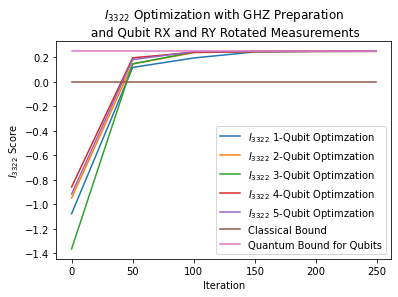

In [6]:
for i, opt_dict in enumerate(sampled_optimizations):
    plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"$I_{3322}$" + f" {i+1}-Qubit Optimzation")
    
plt.plot(opt_dict["samples"], [0]*len(opt_dict["samples"]), label = "Classical Bound")
plt.plot(opt_dict["samples"], [0.25]*len(opt_dict["samples"]), label = "Quantum Bound for Qubits")
plt.title(r"$I_{3322}$ Optimization with GHZ Preparation" +  "\n and Qubit RX and RY Rotated Measurements")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

### Bell State Copy Preparations

An alternative state preparation is when Alice and Bob share $N$ entangled Bell pairs.
An interesting observation is that for this case, the quantum violation of $0.25$ can be obtained using only RY rotations on each measured qubit wire.

In [7]:
bell_copies_optimizations = []
for n_local_qubits in range(1,6):
    bell_copies_prepare_nodes = [QNopt.PrepareNode(1,range(2*n_local_qubits),QNopt.bell_state_copies, 0)]
    local_rxry_measure_nodes = [
        QNopt.MeasureNode(3,2, range(n_local_qubits), QNopt.local_RY, n_local_qubits),
        QNopt.MeasureNode(3,2, range(n_local_qubits, 2*n_local_qubits), QNopt.local_RY, n_local_qubits)
    ]

    bell_copies_local_rxry_ansatz = QNopt.NetworkAnsatz(bell_copies_prepare_nodes, local_rxry_measure_nodes)
    
    opt_dict = {"opt_score" : 0}
    while opt_dict["opt_score"] < 0.24:
        print("n_local_qubits : ", n_local_qubits)
        bell_copies_local_rxry_settings = bell_copies_local_rxry_ansatz.rand_scenario_settings()
        I_3322_cost_bell_copies_local_rxry = QNopt.I_3322_bell_inequality_cost(bell_copies_local_rxry_ansatz) 
        
        start = time.time()
        opt_dict = QNopt.gradient_descent(I_3322_cost_bell_copies_local_rxry, bell_copies_local_rxry_settings, step_size = 0.15, num_steps=300)
        stop = time.time()
        print("opt_score : ", opt_dict["opt_score"])
        print("elapsed time : ", stop - start)
        
    bell_copies_optimizations.append(opt_dict)    

n_local_qubits :  1
iteration :  0 , score :  -1.116843949194426
iteration :  25 , score :  0.10423328846355684
iteration :  50 , score :  0.11961924676238844
iteration :  75 , score :  0.13490482046574792
iteration :  100 , score :  0.1804168351269242
iteration :  125 , score :  0.23068576890086012
iteration :  150 , score :  0.24648459593428296
iteration :  175 , score :  0.2493357186282057
iteration :  200 , score :  0.2498649367806003
iteration :  225 , score :  0.24997170875806018
iteration :  250 , score :  0.24999401758026085
iteration :  275 , score :  0.24999873139418582
opt_score :  0.2499997307640891
elapsed time :  8.487544059753418
n_local_qubits :  2
iteration :  0 , score :  -0.7098015919446061
iteration :  25 , score :  0.17012004707262784
iteration :  50 , score :  0.21227469156325496
iteration :  75 , score :  0.23920626897357966
iteration :  100 , score :  0.24793486458368452
iteration :  125 , score :  0.24959960040862006
iteration :  150 , score :  0.24991788760007

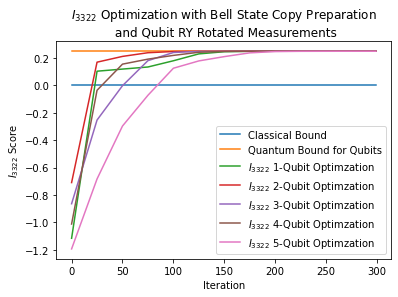

In [8]:
for i, opt_dict in enumerate(bell_copies_optimizations):
    if i == 0:
        plt.plot(opt_dict["samples"], [0]*len(opt_dict["samples"]), label = "Classical Bound")
        plt.plot(opt_dict["samples"], [0.25]*len(opt_dict["samples"]), label = "Quantum Bound for Qubits")
    
    plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"$I_{3322}$" + f" {i+1}-Qubit Optimzation")
    
plt.title(r"$I_{3322}$ Optimization with Bell State Copy Preparation" +  "\n and Qubit RY Rotated Measurements")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

### Two-Qubit Case GHZ State and Arbitrary Measurements

In [9]:
n_local_qubits = 2

ghz_prepare_nodes = [QNopt.PrepareNode(1,range(2*n_local_qubits),QNopt.ghz_state, 0)]
arb_measure_nodes = [
    QNopt.MeasureNode(3,2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 4**(n_local_qubits) - 1),
    QNopt.MeasureNode(3,2, [2,3], qml.templates.subroutines.ArbitraryUnitary, 4**(n_local_qubits) - 1)
]

ghz_arb_ansatz = QNopt.NetworkAnsatz(ghz_prepare_nodes, arb_measure_nodes)

In [10]:
%%time

np.random.seed(1)  # optimization is susceptible to local optima, fixing initial conditions for good example
ghz_arb_settings = ghz_arb_ansatz.rand_scenario_settings()
I_3322_cost_ghz_arb = QNopt.I_3322_bell_inequality_cost(ghz_arb_ansatz)

ghz_arb_opt_dict = QNopt.gradient_descent(I_3322_cost_ghz_arb, ghz_arb_settings, step_size = 0.2, num_steps=250)

iteration :  0 , score :  -0.9393187059336029
iteration :  25 , score :  0.06537843333167537
iteration :  50 , score :  0.1442417563397807
iteration :  75 , score :  0.20303775415459235
iteration :  100 , score :  0.23126883329333203
iteration :  125 , score :  0.24051605759639116
iteration :  150 , score :  0.24432032256395758
iteration :  175 , score :  0.24629945065593695
iteration :  200 , score :  0.24746686664992568
iteration :  225 , score :  0.24820062861559278
CPU times: user 1min 5s, sys: 495 ms, total: 1min 5s
Wall time: 1min 6s


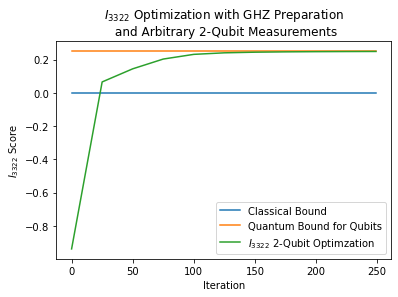

In [11]:
plt.plot(ghz_arb_opt_dict["samples"], [0]*len(ghz_arb_opt_dict["samples"]), label = "Classical Bound")
plt.plot(ghz_arb_opt_dict["samples"], [0.25]*len(ghz_arb_opt_dict["samples"]), label = "Quantum Bound for Qubits")
    
plt.plot(ghz_arb_opt_dict["samples"], ghz_arb_opt_dict["scores"], label = r"$I_{3322}$" + f" {2}-Qubit Optimzation")
    
plt.title(r"$I_{3322}$ Optimization with GHZ Preparation" +  "\n and Arbitrary 2-Qubit Measurements")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

### Two-Qubit Case Bell Copy Preparation and Arbitrary Measurement

In [12]:
n_local_qubits = 2

bell_copy_prepare_nodes = [QNopt.PrepareNode(1,range(2*n_local_qubits),QNopt.bell_state_copies, 0)]
arb_measure_nodes = [
    QNopt.MeasureNode(3,2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 4**(n_local_qubits) - 1),
    QNopt.MeasureNode(3,2, [2,3], qml.templates.subroutines.ArbitraryUnitary, 4**(n_local_qubits) - 1)
]

bell_copy_arb_ansatz = QNopt.NetworkAnsatz(bell_copy_prepare_nodes, arb_measure_nodes)

In [13]:
%%time

bell_copy_arb_settings = bell_copy_arb_ansatz.rand_scenario_settings()
I_3322_cost_bell_copy_arb = QNopt.I_3322_bell_inequality_cost(bell_copy_arb_ansatz) 

bell_copy_arb_opt_dict = QNopt.gradient_descent(I_3322_cost_bell_copy_arb, bell_copy_arb_settings, step_size = 0.2, num_steps=250)

iteration :  0 , score :  -0.9803150968491762
iteration :  25 , score :  0.09801141465695173
iteration :  50 , score :  0.2010958938548597
iteration :  75 , score :  0.23255446831454307
iteration :  100 , score :  0.24290677862809656
iteration :  125 , score :  0.24700681732690621
iteration :  150 , score :  0.2487592269870535
iteration :  175 , score :  0.2494967660853583
iteration :  200 , score :  0.24979768846149353
iteration :  225 , score :  0.2499181395987533
CPU times: user 1min 2s, sys: 293 ms, total: 1min 2s
Wall time: 1min 2s


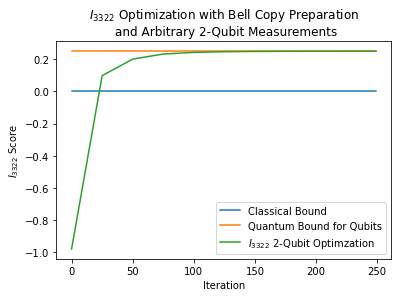

In [14]:
plt.plot(bell_copy_arb_opt_dict["samples"], [0]*len(bell_copy_arb_opt_dict["samples"]), label = "Classical Bound")
plt.plot(bell_copy_arb_opt_dict["samples"], [0.25]*len(bell_copy_arb_opt_dict["samples"]), label = "Quantum Bound for Qubits")
    
plt.plot(bell_copy_arb_opt_dict["samples"], bell_copy_arb_opt_dict["scores"], label = r"$I_{3322}$" + f" {2}-Qubit Optimzation")
    
plt.title(r"$I_{3322}$ Optimization with Bell Copy Preparation" +  "\n and Arbitrary 2-Qubit Measurements")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

### Hardware Oriented Multi-Qubit Measurement Ansatz

In [15]:
n_local_qubits = 4

def simplified_two_design_meas(settings,wires):
        qml.templates.layers.SimplifiedTwoDesign(settings[0:4],np.reshape(settings[4:], (3,3,2)), wires)

simplified_prepare_nodes = [QNopt.PrepareNode(1,range(2*n_local_qubits), QNopt.bell_state_copies, 0)]
simplified_measure_nodes = [
    QNopt.MeasureNode(3,2, [0,1,2,3], simplified_two_design_meas, 22),
    QNopt.MeasureNode(3,2, [4,5,6,7], simplified_two_design_meas, 22)
]

simplified_ansatz = QNopt.NetworkAnsatz(simplified_prepare_nodes, simplified_measure_nodes)

In [16]:
%%time

simplified_settings = simplified_ansatz.rand_scenario_settings()
I_3322_cost_simplified = QNopt.I_3322_bell_inequality_cost(simplified_ansatz) 

simplified_opt_dict = QNopt.gradient_descent(I_3322_cost_simplified, simplified_settings, step_size = 0.5, num_steps=250)

iteration :  0 , score :  -1.1073378107604512
iteration :  25 , score :  -0.30658028926426595
iteration :  50 , score :  -0.10916477393500168
iteration :  75 , score :  0.08428847355963459
iteration :  100 , score :  0.14189421206005548
iteration :  125 , score :  0.15633365995559928
iteration :  150 , score :  0.1674403226316592
iteration :  175 , score :  0.17850248764758136
iteration :  200 , score :  0.18654243169397233
iteration :  225 , score :  0.19892426560453902
CPU times: user 1min 24s, sys: 298 ms, total: 1min 24s
Wall time: 1min 25s


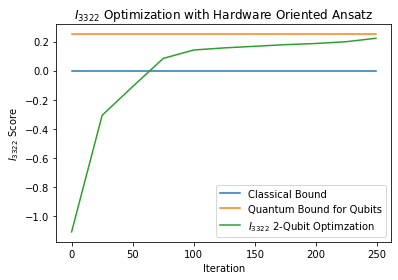

In [17]:
plt.plot(simplified_opt_dict["samples"], [0]*len(simplified_opt_dict["samples"]), label = "Classical Bound")
plt.plot(simplified_opt_dict["samples"], [0.25]*len(simplified_opt_dict["samples"]), label = "Quantum Bound for Qubits")
    
plt.plot(simplified_opt_dict["samples"], simplified_opt_dict["scores"], label = r"$I_{3322}$" + f" {2}-Qubit Optimzation")
    
plt.title(r"$I_{3322}$ Optimization with Hardware Oriented Ansatz")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

### Strongly Entangling Layers Multi-Qubit Ansatz

In [18]:
n_local_qubits = 4

def strongly_entangling_prep(settings, wires):
    qml.templates.layers.StronglyEntanglingLayers(np.reshape(settings, (2,8,3)), wires)

def strongly_entangling_meas(settings, wires):
    qml.adjoint(qml.templates.layers.StronglyEntanglingLayers)(np.reshape(settings, (2,4,3)), wires)

entangling_prepare_nodes = [QNopt.PrepareNode(1,range(2*n_local_qubits), strongly_entangling_prep, 48)]
entangling_measure_nodes = [
    QNopt.MeasureNode(3,2, [0,1,2,3], strongly_entangling_meas, 24),
    QNopt.MeasureNode(3,2, [4,5,6,7], strongly_entangling_meas, 24)
]

entangling_ansatz = QNopt.NetworkAnsatz(entangling_prepare_nodes, entangling_measure_nodes)

In [21]:
%%time

entangling_settings = entangling_ansatz.rand_scenario_settings()
I_3322_cost_entangling = QNopt.I_3322_bell_inequality_cost(entangling_ansatz) 

entangling_opt_dict = QNopt.gradient_descent(I_3322_cost_entangling, entangling_settings, step_size = 0.6, num_steps=250)

iteration :  0 , score :  -0.9253834044188355
iteration :  25 , score :  -0.3732261812557328
iteration :  50 , score :  -0.3003983347391399
iteration :  75 , score :  -0.24806923343949228
iteration :  100 , score :  -0.20419293652369808
iteration :  125 , score :  -0.17486773905656283
iteration :  150 , score :  -0.1561168476914664
iteration :  175 , score :  -0.13865635211915173
iteration :  200 , score :  -0.11692153298868568
iteration :  225 , score :  -0.08729730257331181
CPU times: user 2min 22s, sys: 647 ms, total: 2min 22s
Wall time: 2min 23s


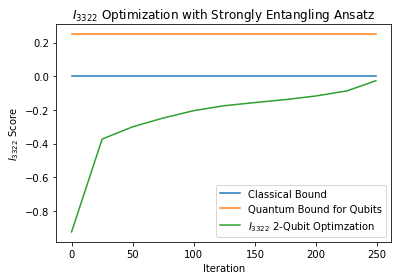

In [22]:
plt.plot(entangling_opt_dict["samples"], [0]*len(entangling_opt_dict["samples"]), label = "Classical Bound")
plt.plot(entangling_opt_dict["samples"], [0.25]*len(entangling_opt_dict["samples"]), label = "Quantum Bound for Qubits")
    
plt.plot(entangling_opt_dict["samples"], entangling_opt_dict["scores"], label = r"$I_{3322}$" + f" {2}-Qubit Optimzation")
    
plt.title(r"$I_{3322}$ Optimization with Strongly Entangling Ansatz")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()